In [1]:
import pandas as pd
import sys
import numpy as np
import tqdm
import scipy.stats as stats
import matplotlib.pyplot as plt

FIG_DIR = '/home/groups/dpwall/briannac/alt_haplotypes/results/autism_and_sex_association/'

# Unfinished files.

In [2]:
import glob
finished = [int(i.split('_')[-1][:4]) for i in glob.glob('/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/pvals_asd/pvals_asd_*.tsv')]
set(range(160)).difference(finished)
# Looks like everthing finished.

set()

In [2]:
bam_mappings = pd.read_table('/home/groups/dpwall/briannac/general_data/bam_mappings.csv', index_col=1)
bam_mappings = bam_mappings[bam_mappings.status=='Passed_QC_analysis_ready']
bam_mappings = bam_mappings.drop('09C86428')

# Sex Association

In [4]:
# Get pairings.
samples = bam_mappings.index
affected_pairs = []
unaffected_pairs = []
for f in set(bam_mappings.family):
    fam = bam_mappings[(bam_mappings.family==f) & (bam_mappings.relationship=='sibling')]
    #random
    #sex_numeric = fam.sex_numeric.copy()
    #np.random.shuffle(sex_numeric)
    #fam.sex_numeric = sex_numeric
    affected_females = fam[(fam.sex_numeric=='2.0') & (fam.derived_affected_status=='autism')]
    affected_males = fam[(fam.sex_numeric=='1.0') & (fam.derived_affected_status=='autism')]
    unaffected_females = fam[(fam.sex_numeric=='2.0') & (pd.isna(fam.derived_affected_status))]
    unaffected_males = fam[(fam.sex_numeric=='1.0') & (pd.isna(fam.derived_affected_status))]
    
    affected_pairs = affected_pairs + [(i,j) for i in affected_females.index for j in affected_males.index if ((i in samples) and (j in samples))]
    unaffected_pairs = unaffected_pairs + [(i,j) for i in unaffected_females.index for j in unaffected_males.index if ((i in samples) and (j in samples))]
males = [m for f,m in (affected_pairs + unaffected_pairs)]
females = [f for f,m in (affected_pairs + unaffected_pairs)]    

pvals_sex = pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/results/autism_and_sex_association/pvals_sex.tsv', sep='\t', index_col=0, header=None)
pvals_sex


/home/users/briannac/.local/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,1,2
0,,
0,0.111016,1.139665
5,0.995817,1.000000
8,0.157299,0.994778
10,0.103605,0.989529
14,0.317311,1.002618
...,...,...
999993,0.014306,0.984334
999995,0.998525,1.000000
999996,0.157299,0.994778


In [4]:
pvals_sex[1] = [max(p,1e-20) for p in pvals_sex[1]] # Clip pvalues.
pvals_sex[2] = [max(e,-2) if e<0 else min(e,2) for e in np.log2(pvals_sex[2])] # Clip pvalues.


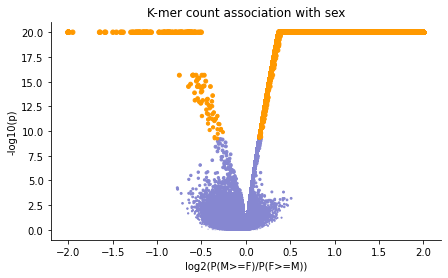

In [5]:
#pvals_sex = pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/results/autism_and_sex_association/pvals_sex.tsv', sep='\t', index_col=0, header=None)
#kmer_covs_sex = pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/results/autism_and_sex_association/sig_covs_sex.tsv', sep='\t', index_col=0, header=None)
#kmer_covs_sex.columns = bam_mappings.index

cutoff = .05/len(pvals_sex)
no_sig =pvals_sex[pvals_sex[1]>=cutoff].sample(frac=.01)
yes_sig = pvals_sex[pvals_sex[1]<cutoff].sample(frac=.01)

f, ax = plt.subplots(figsize=(7,4))
plt.scatter(no_sig[2], -np.log10(no_sig[1]),
            s=-np.log10(no_sig[1]), color='#8687d1')
plt.scatter(yes_sig[2], -np.log10(yes_sig[1]),
            s=-np.log10(yes_sig[1]), color='#ff9900')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
#ax.spines['left'].set_visible(False)
plt.xlabel('log2(P(M>=F)/P(F>=M))')
plt.ylabel('-log10(p)')
plt.title('K-mer count association with sex')
plt.savefig(FIG_DIR + 'kmer_count_association_w_sex.svg', transparent=True)
plt.savefig(FIG_DIR + 'kmer_count_association_w_sex.pdf', transparent=True)
plt.show()

# Autism

In [9]:
print("test")

test


In [3]:
samples = bam_mappings.index
male_pairs = []
female_pairs = []
for f in set(bam_mappings.family):
    fam = bam_mappings[(bam_mappings.family==f) & (bam_mappings.relationship=='sibling')]
    affected_females = fam[(fam.sex_numeric=='2.0') & (fam.derived_affected_status=='autism')]
    affected_males = fam[(fam.sex_numeric=='1.0') & (fam.derived_affected_status=='autism')]
    unaffected_females = fam[(fam.sex_numeric=='2.0') & (pd.isna(fam.derived_affected_status))]
    unaffected_males = fam[(fam.sex_numeric=='1.0') & (pd.isna(fam.derived_affected_status))]
    
    male_pairs = male_pairs + [(i,j) for i in affected_males.index for j in unaffected_males.index if ((i in samples) and (j in samples))]
    female_pairs = female_pairs + [(i,j) for i in affected_females.index for j in unaffected_females.index if ((i in samples) and (j in samples))]
affecteds = [a for a,u in (male_pairs + female_pairs)]
unaffecteds = [u for a,u in (male_pairs + female_pairs)]    

In [4]:
pvals_asd = pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/results/autism_and_sex_association/pvals_asd.tsv', sep='\t', index_col=0, header=None)

/home/users/briannac/.local/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


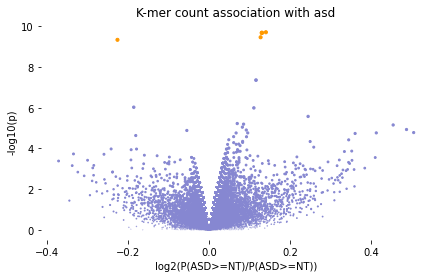

In [7]:
#pvals_asd = pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/results/autism_and_sex_association/pvals_asd.tsv', sep='\t', index_col=0, header=None)
#sampled_df=pd.concat([pvals_asd[pvals_asd[1]>=1e-8].sample(frac=.1),pvals_asd[pvals_asd[1]<1e-8]])
#kmer_covs_asd = pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/results/autism_and_sex_association/sig_covs_asd.tsv', sep='\t', index_col=0, header=None)
#kmer_covs_asd.columns = bam_mappings.index
cutoff = .05/len(pvals_asd)
no_sig =pvals_asd[pvals_asd[1]>=cutoff].sample(frac=.001)
yes_sig = pvals_asd[pvals_asd[1]<cutoff]


f, ax = plt.subplots(figsize=(7,4))

plt.scatter(np.log2(no_sig[2]), -np.log10(no_sig[1]),
            s=-np.log10(no_sig[1]), color='#8687d1')
plt.scatter(np.log2(yes_sig[2]), -np.log10(yes_sig[1]),
            s=-np.log10(yes_sig[1]), color='#ff9900')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.xlabel('log2(P(ASD>=NT)/P(ASD>=NT))')
plt.ylabel('-log10(p)')
plt.title('K-mer count association with asd')
plt.savefig(FIG_DIR + 'kmer_count_association_w_asd.svg', transparent=True)
plt.savefig(FIG_DIR + 'kmer_count_association_w_asd.pdf', transparent=True)
plt.show()

In [37]:
kmer_covs_asd = pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/results/autism_and_sex_association/sig_covs_asd.tsv', sep='\t', index_col=0, header=None)
kmer_covs_asd.columns = bam_mappings.index


(array([404.,   0.,   0.,   0.,   0.,   0.,   0.,  62.,   0.,   0.,   0.,
         26.,   0.,   0.,   0.,   9.,   0.,   0.,   4.]),
 array([0.        , 0.26315789, 0.52631579, 0.78947368, 1.05263158,
        1.31578947, 1.57894737, 1.84210526, 2.10526316, 2.36842105,
        2.63157895, 2.89473684, 3.15789474, 3.42105263, 3.68421053,
        3.94736842, 4.21052632, 4.47368421, 4.73684211, 5.        ]),
 <BarContainer object of 19 artists>)

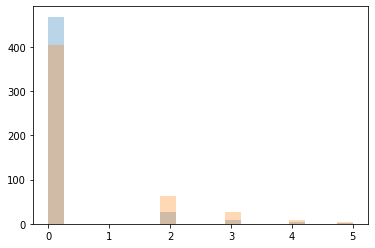

In [44]:
bins = np.linspace(min(kmer_covs_asd[affecteds].iloc[0].values),
                   max(kmer_covs_asd[affecteds].iloc[0].values),
                   20)
plt.hist(kmer_covs_asd[affecteds].iloc[0].values, alpha=.3, bins=bins) 
plt.hist(kmer_covs_asd[unaffecteds].iloc[0].values, alpha=.3, bins=bins)


(array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <a list of 512 BarContainer objects>)

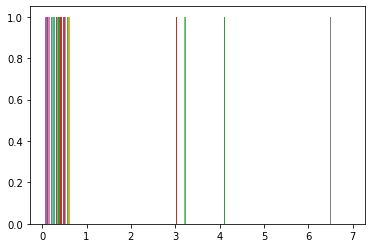

In [41]:
plt.hist(kmer_covs_asd[unaffecteds].iloc[0].values)